In [13]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [14]:

def read_data(path_list, im_size=(224, 224)):

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}
    print(tag2idx)

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                # im = quantize_image(im)
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)

    return X, y, tag2idx

In [20]:
def plot_sample(X):
    # Plotting 9 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(8, 8))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])

In [2]:
IM_SIZE = (256, 256)
NUM_EPOCHS = 50
BATCH_SIZE = 8
TEST_SPLIT = 0.2
BASE_LEARNING_RATE = 1e-3
RANDOM_STATE = 42
VERBOSE_LEVEL = 1

In [37]:
path_list = ['D:\data\Grape___Black_rot']  # Replace with your actual paths
X, y, tag2idx = read_data(path_list,IM_SIZE )

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Label dictionary: {tag2idx}")

{'Grape___Black_rot': 0}


100%|██████████| 384/384 [00:00<00:00, 984.49it/s]

Data shape: (384, 256, 256, 3)
Labels shape: (384, 1)
Label dictionary: {'Grape___Black_rot': 0}


In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT, shuffle=True, stratify=y,random_state=RANDOM_STATE)

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

In [5]:

def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(input_img)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder=Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=BASE_LEARNING_RATE), loss='mean_squared_error')
    return autoencoder

In [6]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=50, verbose=VERBOSE_LEVEL)
early_stopping = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=VERBOSE_LEVEL)
print(x_train.shape[1:])

(256, 256, 3)


In [7]:
autoencoder = build_autoencoder((256, 256, 3))
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[reduce_lr, early_stopping],
    verbose=1

)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - loss: 0.0368 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - loss: 0.0079 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - loss: 0.0063 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - loss: 0.0062 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - loss: 0.0056 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - loss: 0.0051 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0049 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - loss: 0.0048 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - loss: 0.0047 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 10/50
39/39 ━

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 921ms/step - loss: 0.0037
Test Loss: 0.0036273912992328405
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step


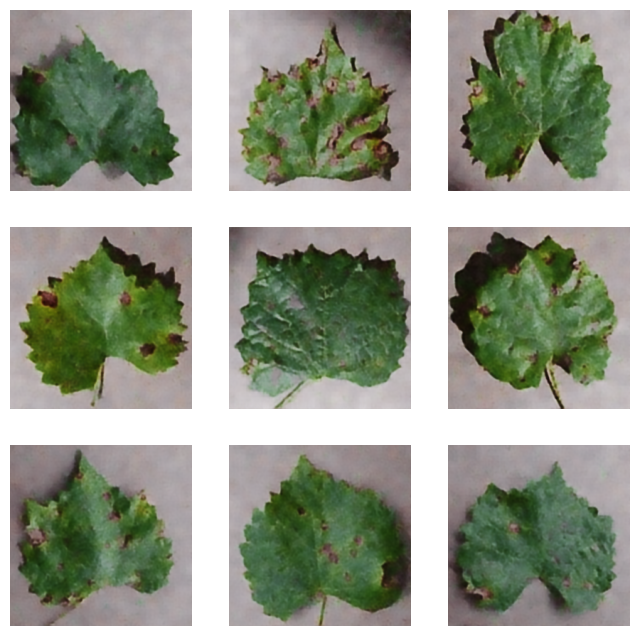

In [8]:
loss = autoencoder.evaluate(x_test_noisy, x_test)
print(f"Test Loss: {loss}")

# Predict and visualize
decoded_imgs = autoencoder.predict(x_test_noisy)
plot_sample(decoded_imgs)

In [24]:
decoded_imgs = autoencoder.predict(x_test_noisy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 890ms/step


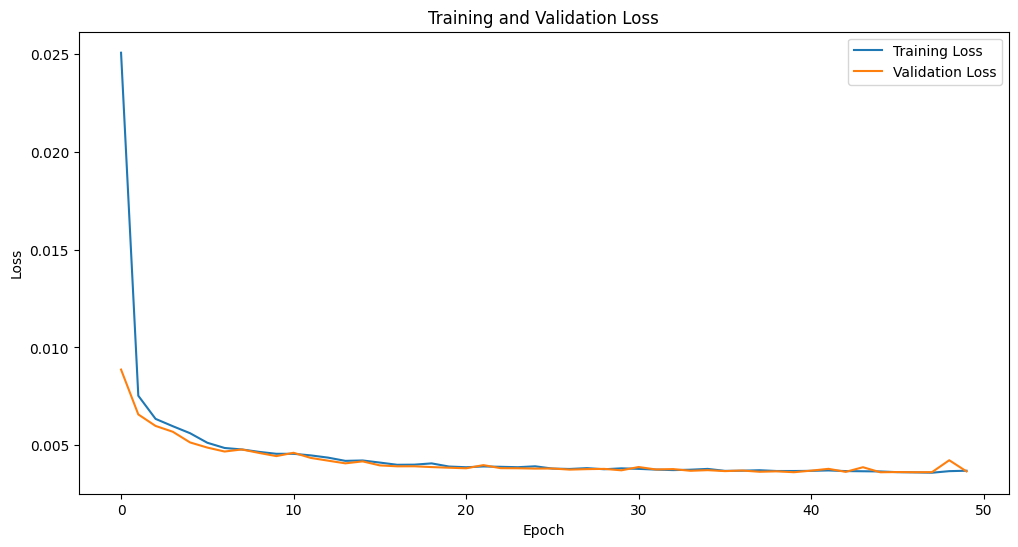

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

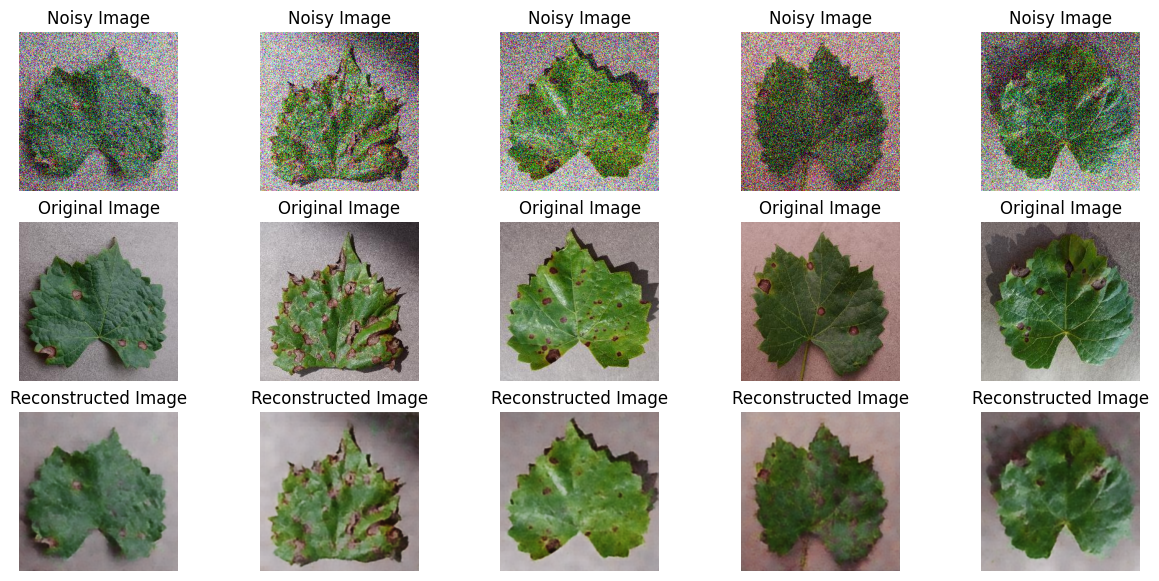

In [38]:
def plot_examples(original, noisy, reconstructed, num_examples=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_examples):
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(noisy[i])
        plt.title('Noisy Image')
        plt.axis('off')
        
        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(original[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        plt.imshow(reconstructed[i])
        plt.title('Reconstructed Image')
        plt.axis('off')
    plt.show()

# Plot some example images
plot_examples(x_test, x_test_noisy, decoded_imgs)

In [27]:
autoencoder.save('autoencoder_model.keras')

In [29]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,994,379 (15.24 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,662,920 (10.16 MB)

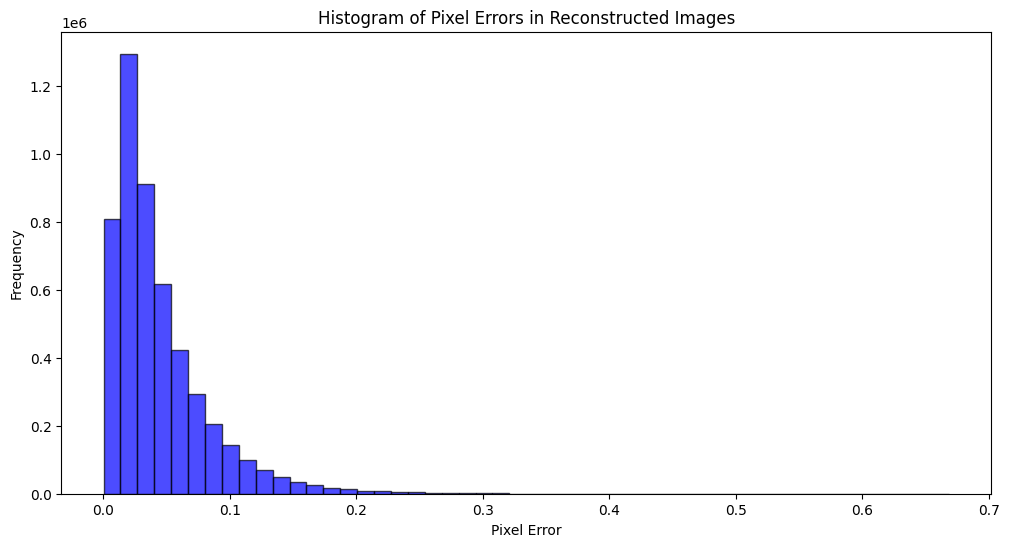

In [32]:
def plot_pixel_errors(original, noisy, reconstructed):
    errors = np.abs(reconstructed - original)
    errors = np.mean(errors, axis=-1)  # Average over color channels
    plt.figure(figsize=(12, 6))
    plt.hist(errors.ravel(), bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Histogram of Pixel Errors in Reconstructed Images')
    plt.xlabel('Pixel Error')
    plt.ylabel('Frequency')
    plt.show()

# Plot pixel errors
plot_pixel_errors(x_test, x_test_noisy, decoded_imgs)